# Quaternion-Based Camera Calibration Tutorial

In this tutorial, we will learn how to perform camera calibration using quaternions to represent the rotation part of the camera’s extrinsic parameters. Quaternions provide a compact and singularity‐free representation of rotations, which can be advantageous when optimizing the calibration parameters.

**Outline:**
1. [Introduction](#Introduction)
2. [Background on Quaternions](#Background-on-Quaternions)
3. [Camera Projection Model](#Camera-Projection-Model)
4. [Synthetic Data Generation](#Synthetic-Data-Generation)
5. [Formulating the Calibration Problem](#Formulating-the-Calibration-Problem)
6. [Optimization and Estimation](#Optimization-and-Estimation)
7. [Results and Visualization](#Results-and-Visualization)
8. [Conclusion](#Conclusion)

<!-- <img src="https://media.springernature.com/m312/springer-static/image/art%3A10.1007%2Fs00371-023-02952-5/MediaObjects/371_2023_2952_Fig1_HTML.png?" alt="drawing" width="600"/> -->
<img src="https://ar5iv.labs.arxiv.org/html/2003.04626/assets/figs/pnp_setting.png" alt="drawing" width="600"/>

### Introduction

Camera calibration is the process of determining the parameters of the camera model. In particular, we are interested in the intrinsic parameters (focal length, principal point, etc.) and extrinsic parameters (rotation and translation that relate the world coordinate system to the camera coordinate system).

In this tutorial, we use **quaternions** to parameterize the rotation. This approach avoids some of the pitfalls (like gimbal lock) associated with Euler angles and often leads to more robust optimization.

We will:
- Review the necessary quaternion mathematics.
- Define the camera projection model.
- Generate synthetic calibration data.
- Formulate a reprojection error cost function.
- Use optimization (e.g., SciPy’s `least_squares`) to recover the calibration parameters.
- Visualize the calibration results.

### Background on Quaternions

A quaternion is a four-dimensional vector $ q = [q_0, q_1, q_2, q_3] $ that can represent a rotation in 3D space. For a unit quaternion, the following holds:

$$
\|q\| = \sqrt{q_0^2 + q_1^2 + q_2^2 + q_3^2} = 1
$$

Key steps include:
- **Normalization:** Ensuring the quaternion is of unit length.
- **Conversion to Rotation Matrix:** Converting the quaternion into a 3×3 rotation matrix that can be used in the camera model.

Below is a sample code cell that implements these functions.

In [1]:
import numpy as np

def normalize_quaternion(q):
    """Normalize a quaternion to unit length."""
    return q / np.linalg.norm(q)

def quaternion_to_rotation_matrix(q):
    """Convert a normalized quaternion to a 3x3 rotation matrix.
    
    The quaternion should be in the form [q0, q1, q2, q3] with q0 as the scalar part.
    """
    q = normalize_quaternion(q)
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])
    return R

# Example usage:
q_example = np.array([0.95, 0.1, 0.1, 0.1])
print("Normalized quaternion:", normalize_quaternion(q_example))
print("Rotation matrix:\n", quaternion_to_rotation_matrix(q_example))

Normalized quaternion: [0.98378271 0.10355607 0.10355607 0.10355607]
Rotation matrix:
 [[ 0.95710456 -0.18230563  0.22520107]
 [ 0.22520107  0.95710456 -0.18230563]
 [-0.18230563  0.22520107  0.95710456]]


### Camera Projection Model

The pinhole camera model is typically expressed as:

$$
\mathbf{p} = \mathbf{K} \, [\mathbf{R} \, | \, \mathbf{t}] \, \mathbf{P}
$$

where:
- **$\mathbf{P}$** is a 3D point in the world (expressed in homogeneous coordinates).
- **$\mathbf{R}$** is the rotation matrix (which we obtain from the quaternion).
- **$\mathbf{t}$** is the translation vector.
- **$\mathbf{K}$** is the intrinsic calibration matrix.
- **$\mathbf{p}$** is the projected 2D point in the image (also in homogeneous coordinates).

In our implementation, we will combine the rotation (via quaternion) and translation into the extrinsic parameters.



The intrinsic matrix **$\mathbf{K}$** encapsulates the internal parameters of the camera that are independent of the external world. It is a 3×3 matrix that transforms the camera’s 3D coordinate system (after applying the extrinsic parameters) into 2D pixel coordinates. The intrinsic matrix is typically represented as:

$$
\mathbf{K} = \begin{bmatrix}
f_x & s & c_x \\
0 & f_y & c_y \\
0 & 0 & 1 \\
\end{bmatrix}
$$

where:
- **$f_x$ and $f_y$**: These represent the focal lengths along the $x$ and $y$ axes, respectively, usually measured in pixels. They determine how strongly the camera converges or diverges light rays onto the image plane.
- **$c_x$ and $c_y$**: These are the coordinates of the principal point, which is typically near the center of the image. The principal point is where the optical axis intersects the image plane.
- **$s$**: The skew coefficient accounts for any non-orthogonality between the image axes. In most modern cameras, the sensor’s axes are perpendicular, so this term is often zero.

The intrinsic matrix plays a crucial role in the projection process:
- **Scaling:** The focal lengths $f_x$ and $f_y$ scale the normalized image coordinates into pixel units.
- **Translation:** The principal point $(c_x, c_y)$ translates the origin of the normalized coordinates to the center (or another reference point) of the image.
- **Skew:** The skew parameter $s$ adjusts for any non-rectangular pixel grids, though it is typically zero in most camera systems.

Thus, after the extrinsic transformation $$\mathbf{R} \, | \, \mathbf{t}$$ has mapped a 3D world point $\mathbf{P}$ into the camera coordinate system, the intrinsic matrix $\mathbf{K}$ projects these coordinates onto the 2D image plane by accounting for the camera’s internal characteristics.

In summary, the intrinsic matrix is essential for converting 3D camera coordinates into 2D pixel coordinates, effectively linking the geometry of the scene to the imaging sensor’s properties.

In [2]:
def project_points(P, q, t, K):
    """
    Projects 3D points P (Nx3) into the image using a rotation (given as quaternion q),
    translation vector t, and camera intrinsic matrix K.
    
    Parameters:
        P : ndarray of shape (N, 3)
            3D world points.
        q : ndarray of shape (4,)
            Quaternion representing rotation.
        t : ndarray of shape (3,)
            Translation vector.
        K : ndarray of shape (3, 3)
            Camera intrinsic matrix.
    
    Returns:
        projected_points : ndarray of shape (N, 2)
            2D points in the image.
    """
    R = quaternion_to_rotation_matrix(q)
    # Convert 3D points to homogeneous coordinates
    P_homog = np.hstack((P, np.ones((P.shape[0], 1))))
    
    # Create extrinsic matrix [R|t]
    RT = np.hstack((R, t.reshape(3,1)))
    
    # Project points (before normalization)
    projected_homog = (K @ RT) @ P_homog.T  # shape: (3, N)
    
    # Normalize homogeneous coordinates
    projected = projected_homog[:2, :] / projected_homog[2, :]
    return projected.T

# Example intrinsic matrix (assuming fx=fy=800, principal point at (320, 240))
K_example = np.array([[800,   0, 320],
                      [  0, 800, 240],
                      [  0,   0,   1]])

### Synthetic Data Generation

To test our calibration procedure, we can generate synthetic data:
- Create a set of 3D world points (e.g., points on a calibration grid).
- Choose known ground-truth camera parameters (intrinsics, a quaternion for rotation, and translation).
- Project the 3D points into the image using our camera model.
- Optionally add noise to simulate measurement errors.

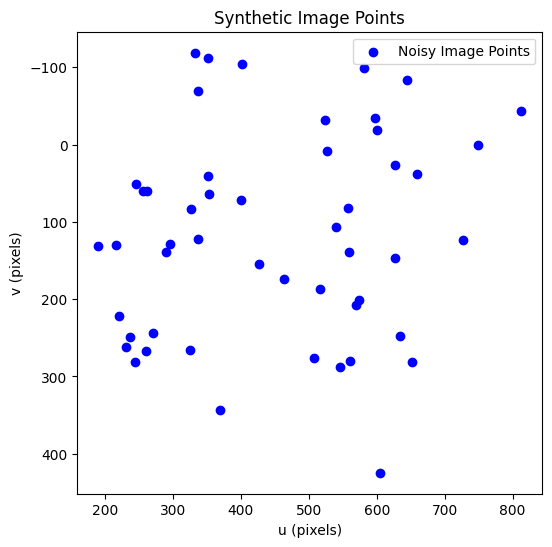

In [3]:
def generate_synthetic_data(num_points=50, noise_std=1.0):
    # Generate random 3D points within a certain range
    P = np.random.uniform(-1, 1, (num_points, 3))
    
    # Define ground-truth parameters
    q_true = normalize_quaternion(np.array([0.9, 0.2, 0.1, 0.1]))
    t_true = np.array([0.5, -0.3, 3.0])
    
    # Use our previously defined intrinsic matrix K_example
    pts_2d = project_points(P, q_true, t_true, K_example)
    
    # Add Gaussian noise to simulate measurement error
    pts_2d_noisy = pts_2d + np.random.normal(0, noise_std, pts_2d.shape)
    
    return P, pts_2d_noisy, q_true, t_true

# Generate the synthetic data
P_world, pts_image, q_true, t_true = generate_synthetic_data()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(pts_image[:,0], pts_image[:,1], c='blue', label='Noisy Image Points')
plt.title("Synthetic Image Points")
plt.xlabel("u (pixels)")
plt.ylabel("v (pixels)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis if needed (image coordinates)
plt.show()

### Formulating the Calibration Problem

We now define a cost function that computes the **reprojection error** between the observed 2D points and the 2D points obtained by projecting the 3D world points with our estimated camera parameters.

The parameter vector to optimize can include:
- The quaternion $ q $ (with 4 parameters; normalization is enforced either explicitly or via a penalty/constraint).
- The translation vector $ t $ (3 parameters).

For simplicity, in this tutorial we assume that the intrinsic matrix $ K $ is known.

In [4]:
from scipy.optimize import least_squares

def reprojection_error(params, P, pts_obs, K):
    """
    Compute the reprojection error.
    
    Parameters:
        params : ndarray of shape (7,)
            First 4 elements are the quaternion, last 3 are the translation vector.
        P : ndarray of shape (N, 3)
            3D world points.
        pts_obs : ndarray of shape (N, 2)
            Observed 2D image points.
        K : ndarray of shape (3, 3)
            Camera intrinsic matrix.
    
    Returns:
        error: Flattened reprojection error vector.
    """
    q = params[:4]
    t = params[4:]
    
    # Ensure the quaternion is normalized
    q = normalize_quaternion(q)
    
    pts_proj = project_points(P, q, t, K)
    error = (pts_proj - pts_obs).ravel()
    return error

# Test the error function with ground truth parameters
params_gt = np.hstack((q_true, t_true))
error_test = reprojection_error(params_gt, P_world, pts_image, K_example)
print("Reprojection error (ground truth):", np.linalg.norm(error_test))

Reprojection error (ground truth): 11.08389850549584


### Optimization and Estimation

We now solve the calibration problem by minimizing the reprojection error using an optimization routine. We will use `scipy.optimize.least_squares` to recover the quaternion and translation vector.

In [5]:
# Initial guess: slightly perturbed from ground truth
q_initial = normalize_quaternion(q_true + np.random.normal(0, 0.1, 4))
t_initial = t_true + np.random.normal(0, 0.1, 3)
params_initial = np.hstack((q_initial, t_initial))

# Run the optimization
result = least_squares(reprojection_error, params_initial, args=(P_world, pts_image, K_example))

params_est = result.x
q_est = normalize_quaternion(params_est[:4])
t_est = params_est[4:]
print("Estimated quaternion:", q_est)
print("Estimated translation:", t_est)

# Compare with ground truth
print("Ground truth quaternion:", q_true)
print("Ground truth translation:", t_true)

Estimated quaternion: [0.96470497 0.2151278  0.10728555 0.1074903 ]
Estimated translation: [ 0.49891002 -0.29892052  2.99730721]
Ground truth quaternion: [0.96490128 0.21442251 0.10721125 0.10721125]
Ground truth translation: [ 0.5 -0.3  3. ]


### Results and Visualization

After the optimization, we can visualize how well the estimated parameters reproject the 3D points compared to the noisy observations. A good calibration will show a low reprojection error and a close match between the estimated and ground truth parameters.

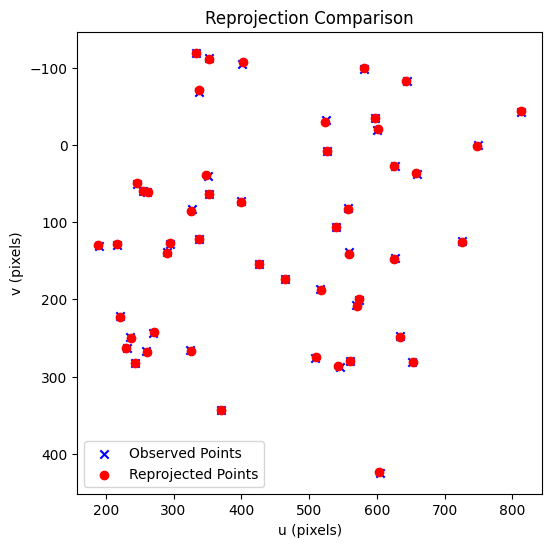

Final reprojection error: 10.855252789160152


In [6]:
# Compute reprojected points using the estimated parameters
pts_proj_est = project_points(P_world, q_est, t_est, K_example)

plt.figure(figsize=(6,6))
plt.scatter(pts_image[:,0], pts_image[:,1], c='blue', marker='x', label='Observed Points')
plt.scatter(pts_proj_est[:,0], pts_proj_est[:,1], c='red', marker='o', facecolors='none', label='Reprojected Points')
plt.title("Reprojection Comparison")
plt.xlabel("u (pixels)")
plt.ylabel("v (pixels)")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Compute final reprojection error
final_error = np.linalg.norm(reprojection_error(params_est, P_world, pts_image, K_example))
print("Final reprojection error:", final_error)

### Conclusion

In this tutorial, we demonstrated a simple calibration procedure that uses quaternions to represent the rotation in a camera model. We:
- Reviewed the necessary quaternion math.
- Formulated the camera projection model.
- Generated synthetic calibration data.
- Defined and minimized a reprojection error cost function.
- Compared the estimated calibration parameters with the ground truth.

This framework can be extended to real data, include optimization over intrinsic parameters, or incorporate additional constraints. Experiment further to handle more complex calibration scenarios and noise models.